In [1]:
IMG_PATH = './Rock-image-patches'
CSV_RGB = './colors_RGB.csv'
CSV_LAB = './colors_LAB.csv'

MAX_SIZE = (200, 200)
CLUSTERS = 4

#### Imports

In [2]:
import os
import cv2
import numpy as np
from PIL import Image
from skimage import io, color
import traceback#, sys, logging
from sklearn.cluster import KMeans

def load_images_from_directory(path, max_size=None):
    x_rgb = []; x_lab = []; y = []; files = [];
    for folder in os.listdir(path):
        if(os.path.isfile(folder)):
            print(os.path.join(path,folder), 'was removed')
            continue
        for file in os.listdir(os.path.join(path,folder)):
            if(not file.lower().endswith(('.png', '.jpg', '.jpeg'))):
                print(os.path.join(path,folder,file), 'was removed')
                continue
            try:
                if max_size == None:
                    # pilmode_doc=https://pillow.readthedocs.io/en/3.0.x/handbook/concepts.html
                    img = io.imread(os.path.join(path,folder,file), pilmode='RGB')
                else:
                    img = cv2.imread(os.path.join(path,folder,file)) #img = Image.open(os.path.join(path,folder,file)).convert('RGB'); img.thumbnail(max_size, Image.ANTIALIAS); img = np.array(img); img = io.imread(os.path.join(path,folder,file), pilmode='RGB')
                    img = cv2.resize(img, max_size);
                x_rgb.append(img)
                x_lab.append(color.rgb2lab(img)) # illuminant='D65' #x_lab.append(cv2.cvtColor(img, cv2.COLOR_BGR2LAB))
            except Exception as e:
                print(f"Error in {path}/{folder}/{file} file\n{e}")
                traceback.print_exc() #print(e, file=sys.stderr) #logging.error(e, exc_info=True)
            y.append(folder)
            files.append(file)
        print(folder, "images were loaded")
    return (x_rgb, x_lab, y, files)

def get_dominant_colors(img):
    reshape = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
    cluster = KMeans(n_clusters=CLUSTERS).fit(reshape)
    lb = np.arange(0, len(np.unique(cluster.labels_))+1) # Get the number of different clusters
    (hist, _) = np.histogram(cluster.labels_, bins = lb) # create histogram
    hist = hist.astype("float"); hist /= hist.sum() # normalize
    colors = sorted([(percent, color) for (percent, color) in zip(hist, cluster.cluster_centers_)])
    features = []
    for (percent, color) in colors:
        features.extend(color)
        features.append(percent)
    return features

def get_dominants_plot(features):
    rect = np.zeros((50, 300, 3), dtype=np.uint8)
    start = 0
    for i in range(4):
        color_ = np.array(features[i*4:i*4+3])
        percent = features[i*4+3]
        end = start + (percent * 300)
        cv2.rectangle(rect, (int(start), 0), (int(end), 50), color_.astype("uint8").tolist(), -1)
        start = end
    return rect

def get_avg_plot(img):
    average = img.mean(axis=0).mean(axis=0)
    avg_patch = np.ones(shape=img.shape, dtype=np.uint8)*np.uint8(average)
    return avg_patch

### 1. Loading data

In [3]:
import time

start = time.time()
x_rgb, x_lab, y, files = load_images_from_directory(IMG_PATH, MAX_SIZE)
stop = time.time()

print(f"\nData loading time: {stop - start} s")

Granodiorite images were loaded
./Rock-image-patches/.DS_Store was removed
Granite images were loaded
Diorite images were loaded
Gabbro images were loaded

Data loading time: 27.983901977539062 s


In [4]:
import pandas as pd
print('Data visualization')
classes, indices, counts = np.unique(y, return_counts=True, return_index=True)
df = pd.DataFrame({'Classes': classes, 'Counts': counts, 'Start index': indices})
df.sort_values(by=['Start index'], ascending=True, ignore_index='x')

Data visualization


,Classes,Counts,Start index
0,Granodiorite,70,0
1,Granite,70,70
2,Diorite,78,140
3,Gabbro,65,218


### 2. Determining the best k number for kmeans

Iterating a range number of clusters for kmeans

In [5]:
#print('Image rgb: Gabbro/'+files[217], x_rgb[217].shape)
#reshape_rgb = x_rgb[217].reshape((x_rgb[217].shape[0] * x_rgb[217].shape[1], x_rgb[217].shape[2]))

print('Image lab: Gabbro/'+files[217], x_lab[217].shape)
reshape_lab = x_lab[217].reshape((x_lab[217].shape[0] * x_lab[217].shape[1], x_lab[217].shape[2]))

Nclusters = range(2, 20)
score = []; distortions = []
for n in Nclusters:
    k = KMeans(n_clusters=n)
    k.fit(reshape_lab)
    distortions.append(k.inertia_)
    score.append(k.score(reshape_lab))
    print('Kmeans was trained with k =', n)

Image lab: Gabbro/11828J_P2_02_02.png (200, 200, 3)
Kmeans was trained with k = 2
Kmeans was trained with k = 3
Kmeans was trained with k = 4
Kmeans was trained with k = 5
Kmeans was trained with k = 6
Kmeans was trained with k = 7
Kmeans was trained with k = 8
Kmeans was trained with k = 9
Kmeans was trained with k = 10
Kmeans was trained with k = 11
Kmeans was trained with k = 12
Kmeans was trained with k = 13
Kmeans was trained with k = 14
Kmeans was trained with k = 15
Kmeans was trained with k = 16
Kmeans was trained with k = 17
Kmeans was trained with k = 18
Kmeans was trained with k = 19


Plotting the Elbow curve

In [6]:
# Plot configuration
import matplotlib.pyplot as plt
plt.rc('font', family='Times New Roman')
plt.rc('axes', titlesize=13)
plt.rc('font', size=13)

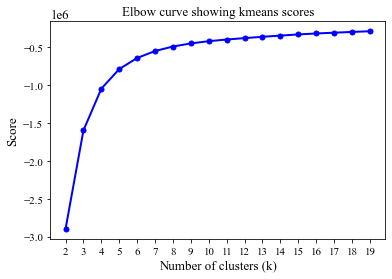

In [7]:
# Plot of Elbow curve with the Kmeans scores
plt.plot(Nclusters, score, 'bo-', linewidth=2,markersize=5)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')
plt.title('Elbow curve showing kmeans scores')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xticks(Nclusters)
#plt.savefig('Elbow curve.png', dpi=300)
plt.show()

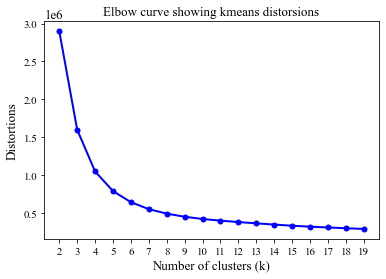

In [8]:
plt.plot(Nclusters, distortions, 'bo-', linewidth=2,markersize=5)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortions')
plt.title('Elbow curve showing kmeans distorsions')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xticks(Nclusters)
#plt.savefig('Elbow curve - distorsions.png', dpi=300)
plt.show()

### 3. Extracting dominant colors from images

In [14]:
extracted_rgb = []
extracted_lab = []

start = time.time()
try:
    i=0
    for rgb in x_rgb:
        features = get_dominant_colors(rgb)
        extracted_rgb.append(features)
        i+=1
except Exception as e:
    print(f"Error in {y[i]}/{files[i]} file, index {i}, rgb shape {x_rgb[i].shape}\n{e}")
    traceback.print_exc()
stop = time.time()
print(f"\nRGB dominant colors extraction time: {stop - start} s")

start = time.time()
try:
    i=0
    for lab in x_lab:
        features = get_dominant_colors(lab)
        extracted_lab.append(features)
        i+=1
except Exception as e:
    print(f"Error in {y[i]}/{files[i]} file, index {i}, lab shape {x_lab[i].shape}\n{e}")
    traceback.print_exc()
stop = time.time()
print(f"\nLAB dominant colors extraction time: {stop - start} s")


RGB dominant colors extraction time: 95.76176595687866 s

LAB dominant colors extraction time: 121.50167679786682 s


Plotting dominant colors in sample images

### 4. Add data to CSV

In [15]:
rgb_df = pd.DataFrame(extracted_rgb, files)
rgb_df[16] = y
rgb_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
11830I_P2_01_02.png,90.913529,91.667843,95.474118,0.127250,193.667835,198.274124,201.275876,0.242500,132.378543,134.787064,138.837482,0.274450,163.296435,167.278185,171.258455,0.355800,Granodiorite
12720V_P2.JPG,85.117997,86.500496,87.824492,0.101075,190.172762,194.564733,199.417718,0.235925,130.286906,133.319711,136.636734,0.271150,159.135769,163.279903,167.637589,0.391850,Granodiorite
10715M_P2_01_02.png,61.795103,64.276197,67.571480,0.138850,104.453947,108.684332,112.411306,0.205200,165.942894,170.087208,173.992005,0.307675,136.124964,140.451645,144.677825,0.348275,Granodiorite
12723M_P2_01_02.png,72.010316,71.261070,72.605142,0.157325,123.524147,125.551728,129.771267,0.226275,192.130703,196.267925,199.507033,0.290275,159.313197,162.676581,166.867881,0.326125,Granodiorite
11830I_P2_01_01.png,92.917330,100.274365,103.365377,0.132400,133.208066,138.460875,141.970205,0.248625,196.187314,198.053292,200.607143,0.268875,166.276810,169.558975,172.638155,0.350100,Granodiorite
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12717C_P2_01_03.png,175.377686,178.062421,179.691688,0.158200,80.009746,82.400104,87.127320,0.241600,143.276485,145.952130,148.260021,0.279400,112.192436,114.146448,117.492413,0.320800,Gabbro
12717B_P2_03_01.png,174.704427,186.429376,189.961972,0.124675,146.882792,153.997706,157.083748,0.261075,102.816903,106.948793,110.071957,0.281250,124.156810,129.284312,132.470579,0.333000,Gabbro
12717B_P2_01_04.png,168.494892,173.816398,176.593011,0.092950,140.374137,144.708426,147.673999,0.235325,98.574804,102.012429,105.983735,0.325850,118.272931,122.128515,125.658113,0.345875,Gabbro
10719CC_P2.jpg,179.810050,184.340871,186.463819,0.149925,143.760004,147.674453,149.321112,0.253025,73.391161,78.204821,80.352500,0.280000,107.696547,112.006386,113.707427,0.317050,Gabbro


In [16]:
lab_df = pd.DataFrame(extracted_lab, files)
lab_df[-1] = y
lab_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,-1
11830I_P2_01_02.png,38.258711,0.824945,-2.291882,0.118325,79.445934,-1.104884,-1.979915,0.254500,55.484105,0.058288,-2.475465,0.267375,67.930191,-0.596658,-2.532175,0.359800,Granodiorite
12720V_P2.JPG,36.101211,-0.123483,-0.919864,0.096175,78.211107,-0.621731,-2.906582,0.246650,55.029967,-0.373928,-2.128211,0.261950,66.564366,-0.606362,-2.751011,0.395225,Granodiorite
10715M_P2_01_02.png,25.928892,-0.051361,-2.327477,0.123725,43.846296,-0.748895,-2.627779,0.186075,68.954755,-0.753559,-2.490767,0.333175,57.160271,-0.683555,-2.773654,0.357025,Granodiorite
12723M_P2_01_02.png,29.649789,0.752919,-0.632236,0.149025,51.638561,0.271452,-2.489827,0.218575,78.669068,-0.858535,-2.085676,0.307000,66.054424,-0.325445,-2.586643,0.325400,Granodiorite
11830I_P2_01_01.png,41.330608,-2.011308,-2.700881,0.122800,56.608012,-1.183498,-2.581626,0.241125,79.571319,-0.205080,-1.440404,0.282250,68.774695,-0.544964,-1.990102,0.353825,Granodiorite
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12717C_P2_01_03.png,71.326094,-0.719197,-1.105727,0.189825,34.146447,0.318806,-3.242299,0.213900,58.901463,-0.421450,-1.560250,0.283675,46.759490,0.025116,-2.140829,0.312600,Gabbro
12717B_P2_03_01.png,74.671948,-3.433433,-3.125979,0.129075,62.843132,-1.959705,-2.436365,0.266725,44.761456,-0.760623,-2.315721,0.271200,53.480674,-1.160129,-2.352651,0.333000,Gabbro
12717B_P2_01_04.png,70.439648,-1.431831,-2.004469,0.097725,59.556871,-1.002608,-2.077441,0.239475,42.891072,-0.362026,-2.744243,0.315200,50.853212,-0.687270,-2.403371,0.347600,Gabbro
10719CC_P2.jpg,73.622849,-1.232760,-1.549613,0.170800,32.185290,-1.335016,-1.967399,0.254575,59.344702,-1.098680,-1.327176,0.268075,45.532367,-1.230429,-1.513243,0.306550,Gabbro


In [17]:
rgb_df.to_csv(CSV_RGB, header=None)
lab_df.to_csv(CSV_LAB, header=None)